In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import EfficientNet
from utils import *

In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

In [4]:
current_time = get_BJ_time()
print(current_time)

0818_05-07-16


# Reading data and Basic EDA(Exploratory Data Analysis)

Here I am going to open the dataset with pandas, check distribution of labels.

In [5]:
df_2015 = pd.read_csv('../input/aptos-data-split/df_2015_raw_sigmaX10.csv')
df_2019 = pd.read_csv('../input/aptos-data-split/df_2019_sigmaX10.csv')

df = pd.concat([df_2015, df_2019]).reset_index(drop=True) # merge train val together
df['is_valid'] = [False]*df_2015.shape[0] + [True]*df_2019.shape[0]

test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [6]:
bs = 24 #smaller batch size is better for training, but may take longer
sz = 256  # get model input size
# sz = EfficientNet.get_image_size(model_name)  # get model input size
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

In [7]:
data = (ImageList.from_df(df=df_2019,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
data

ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,1.0,2.0,1.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,1.0,0.0,4.0,0.0
Path: .;

Test: None

# Training (Transfer learning)

The Kaggle competition used the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [8]:
def qk(y_pred, y):
    k = torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')
    k[k != k] = 0
    k[torch.isinf(k)] = 0
    
    return k

In [9]:
model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

Loaded pretrained weights for efficientnet-b5


In [10]:
SGDW = partial(optim.SGD, momentum=0.9)

In [11]:
learn = Learner(data, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, patience=6)],
                model_dir = '../output/models/',
                opt_func = SGDW)

In [12]:
learn.load("efficientnet-b5_0812_22-06-45_stage2",  with_opt=False)

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,1.0,2.0,1.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,1.0,0.0,4.0,0.0
Path: .;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momen

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 6.31E-08


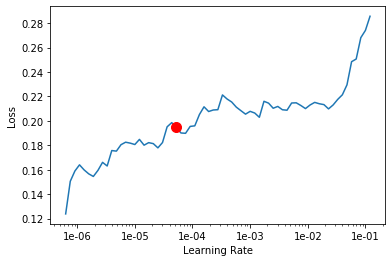

In [55]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [ ]:
model_save_name = "{}_{}_stage3".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 3e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time


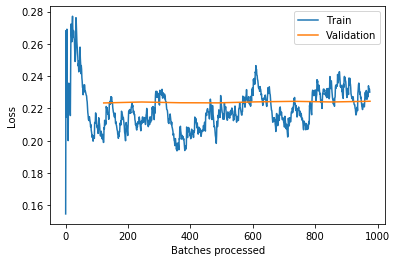

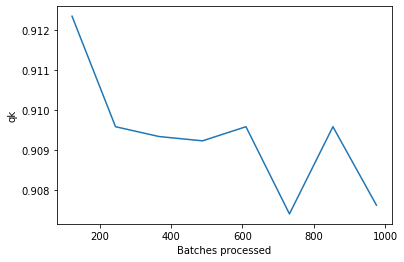

In [36]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [37]:
learn.load(model_save_name)

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,1.0,2.0,1.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,1.0,0.0,4.0,0.0
Path: .;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ., model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3)

# Optimize the Metric
Optimizing the quadratic kappa metric was an important part of the top solutions in the previous competition. Thankfully, @abhishek has already provided code to do this for us. We will use this to improve the score.

In [38]:
import scipy as sp

In [39]:
class OptimizedRounder(object):
    """
    Optimize threshold coefficients.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Customized loss function.
        
        :param coef: list, shape=[4]
            Threshold.
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        # Cohen's kappa: a statistic that measures inter-annotator agreement.
        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        # new function with partial application of the given arguments and keywords.
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Minimization of scalar function of one or more variables.
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        """
        :param X: list, shape=[5]
            Prediction.
        :param coef: list, shape=[4]
            Threshold.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [40]:
# Return predictions and targets on `ds_type` dataset.
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])
coefficients = optR.coefficients()
print(coefficients)

0.9180125412526031
[0.5   1.575 2.5   3.5  ]


# Error Analysis

In [41]:
valid_pred = optR.predict(valid_preds[0], [0.5, 1.5, 2.5, 3.5])
cm = confusion_matrix(valid_pred,valid_preds[1])

Confusion matrix, without normalization
[[362   7   0   0   0]
 [  4  25  15   0   2]
 [  0  35 168   8  15]
 [  0   1  22  18  17]
 [  0   0   1   4  29]]


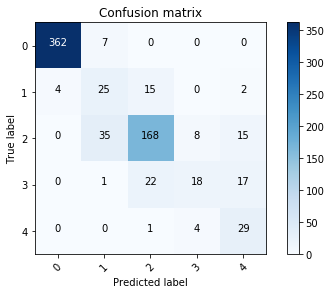

In [42]:
plot_confusion_matrix(cm, classes=range(5), normalize=False)

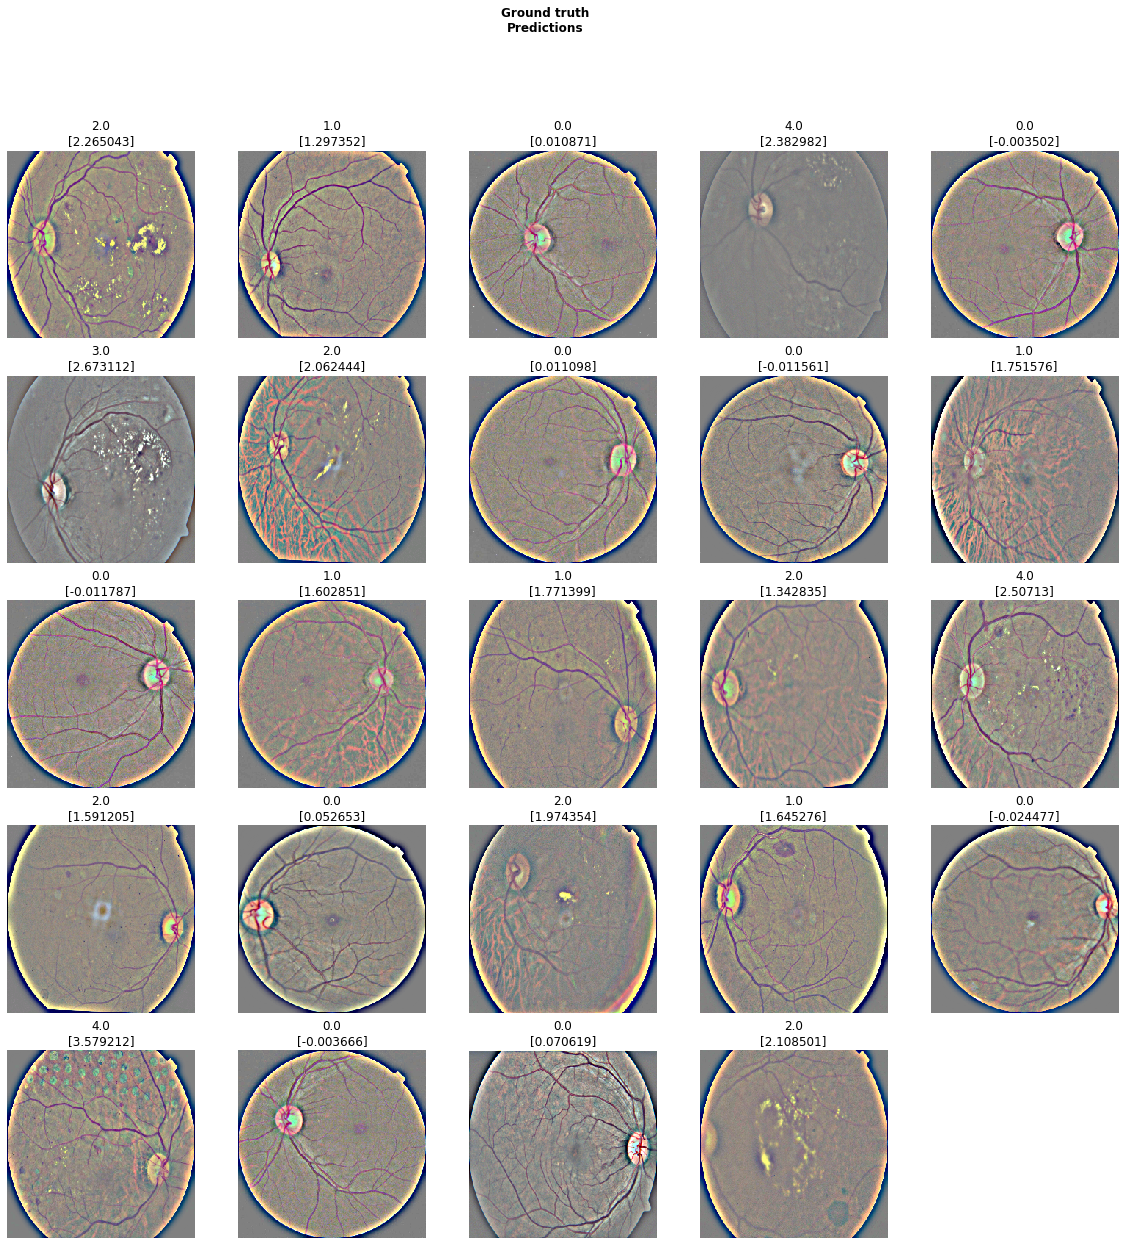

In [43]:
learn.show_results()

# Submission

In [44]:
learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

In [45]:
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, coefficients)
test_df.diagnosis = tst_pred.astype(int)

In [54]:
save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

efficientnet-b5_0818_05-07-16_stage3_submition.csv done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effe7a42518>]], dtype=object)

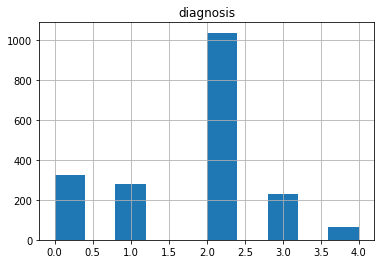

In [47]:
test_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effe795b518>]], dtype=object)

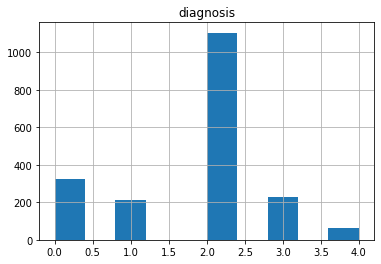

In [48]:
test_df.diagnosis = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.hist()

In [49]:
test_df.diagnosis.value_counts()

2.0    1105
0.0     323
3.0     228
1.0     210
4.0      62
Name: diagnosis, dtype: int64

In [50]:
old = pd.read_csv("0.802.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effe794a6a0>]], dtype=object)

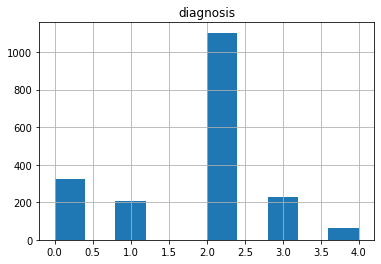

In [51]:
old.hist()

In [52]:
old.diagnosis.value_counts()

2.0    1103
0.0     326
3.0     228
1.0     209
4.0      62
Name: diagnosis, dtype: int64

In [53]:
old.diagnosis.corr(test_df.diagnosis)

0.9970337819981826